# Notes too self:
I have got to put more of his in functions cause this is so busy!

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
import cv2
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
import re
import tools

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up the data and then isolate the individual outlines and save the original image

In [6]:
files = os.listdir(segments_path)
for fichier in files[:]: # filelist[:] makes a copy of filelist.
    if not(fichier.endswith(".npy")):
        files.remove(fichier)

In [7]:
files.sort(key = tools.natural_keys)

In [8]:
dat_list = []
outl_list = []
img_list = []
for file in files:
    dat = np.load(segments_path + file, allow_pickle=True).item()
    dat_list.append(dat)
    # Create a list that contains each outline
    outl = tools.outlines_list(dat['masks'])
    outl_list.append(outl)
    # save a copy of the basic image to be used and latered later. 
    img = dat["img"]
    img_list.append(img)

# Step 2
Look at the individual outlines. (I mostly use this to get the context of where each outline is in the full image)

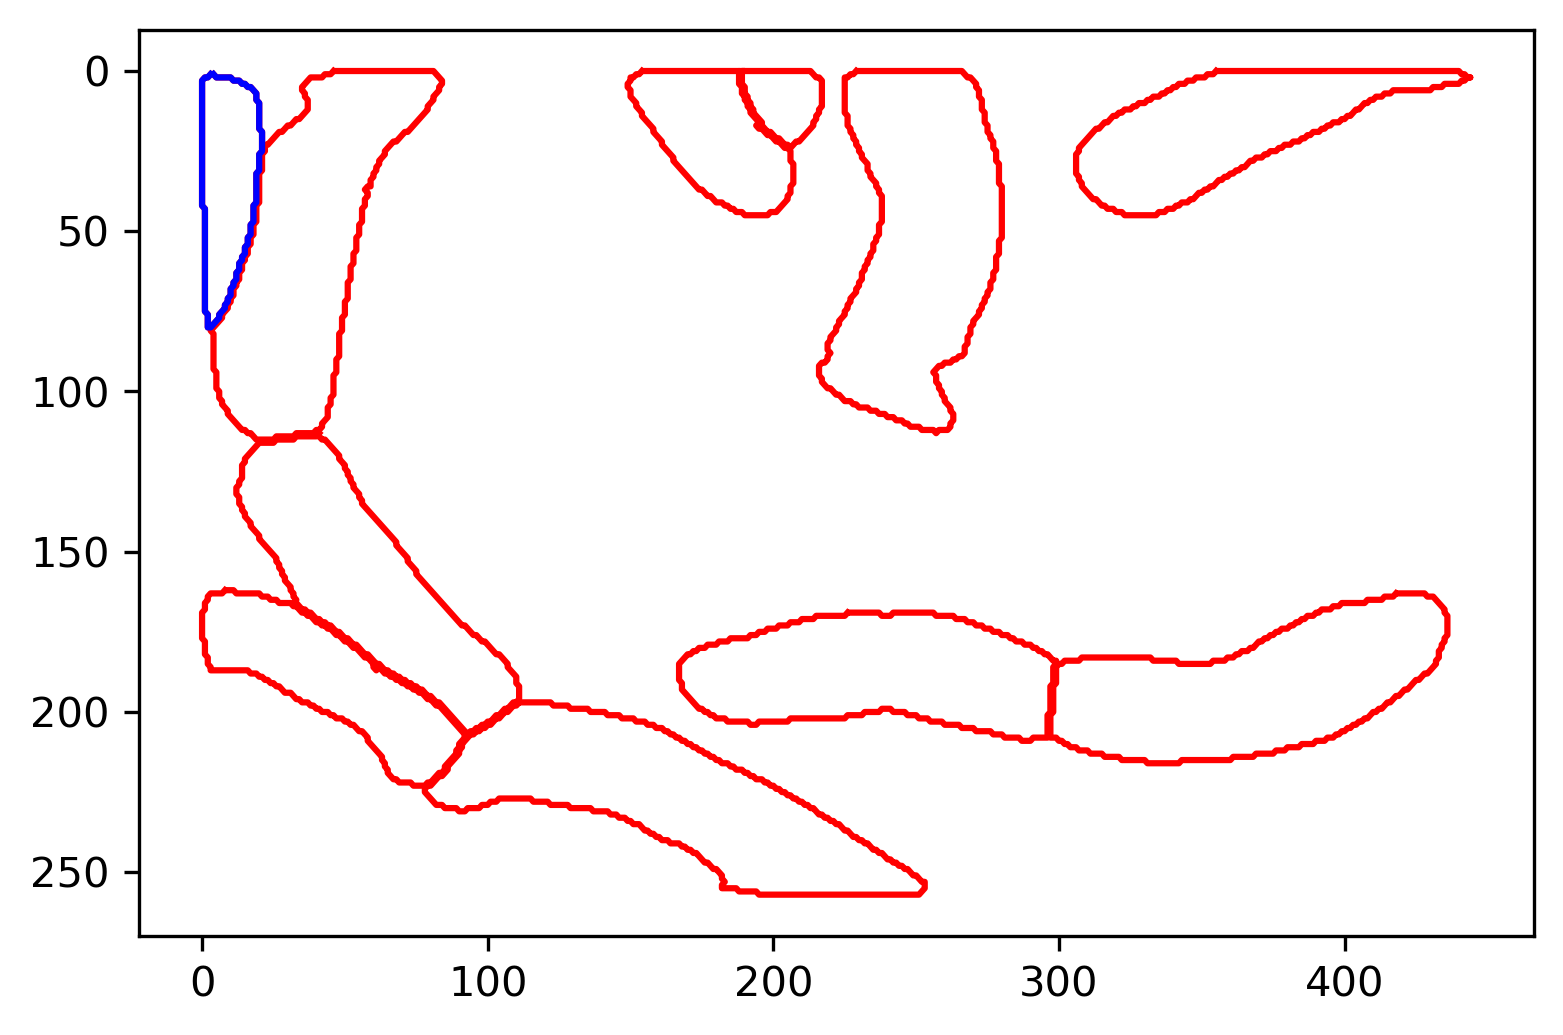

In [5]:
#plot just the outlines. I mostly use this to get a sense for each outline. 
for o in outl_list[13]:
    plt.plot(o[:,0], o[:,1], color='r')
plt.plot(outl_list[13][5][:,0], outl_list[13][5][:,1], color = 'blue')
plt.gca().invert_yaxis()

# Bounding Boxes and Centers

In [9]:
# loop over the contours individually
boxes_list = []
centers_list = []
box_img_list = []
for outl, img in zip(outl_list, img_list):
    boxes = []
    centers = []
    box_img = img.copy()
    for o in outl:
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(o)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        # compute the center of the bounding box
        cX = int(np.average(box[:, 0]))
        cY = int(np.average(box[:, 1]))
        # draw the bounding boxes and centers. 
        cv2.drawContours(box_img, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.circle(box_img, (cX, cY), 4, (255, 255, 255), -1)
        boxes.append(box)
        centers.append([cX, cY])
    boxes_list.append(boxes)
    centers_list.append(centers)
    box_img_list.append(box_img)

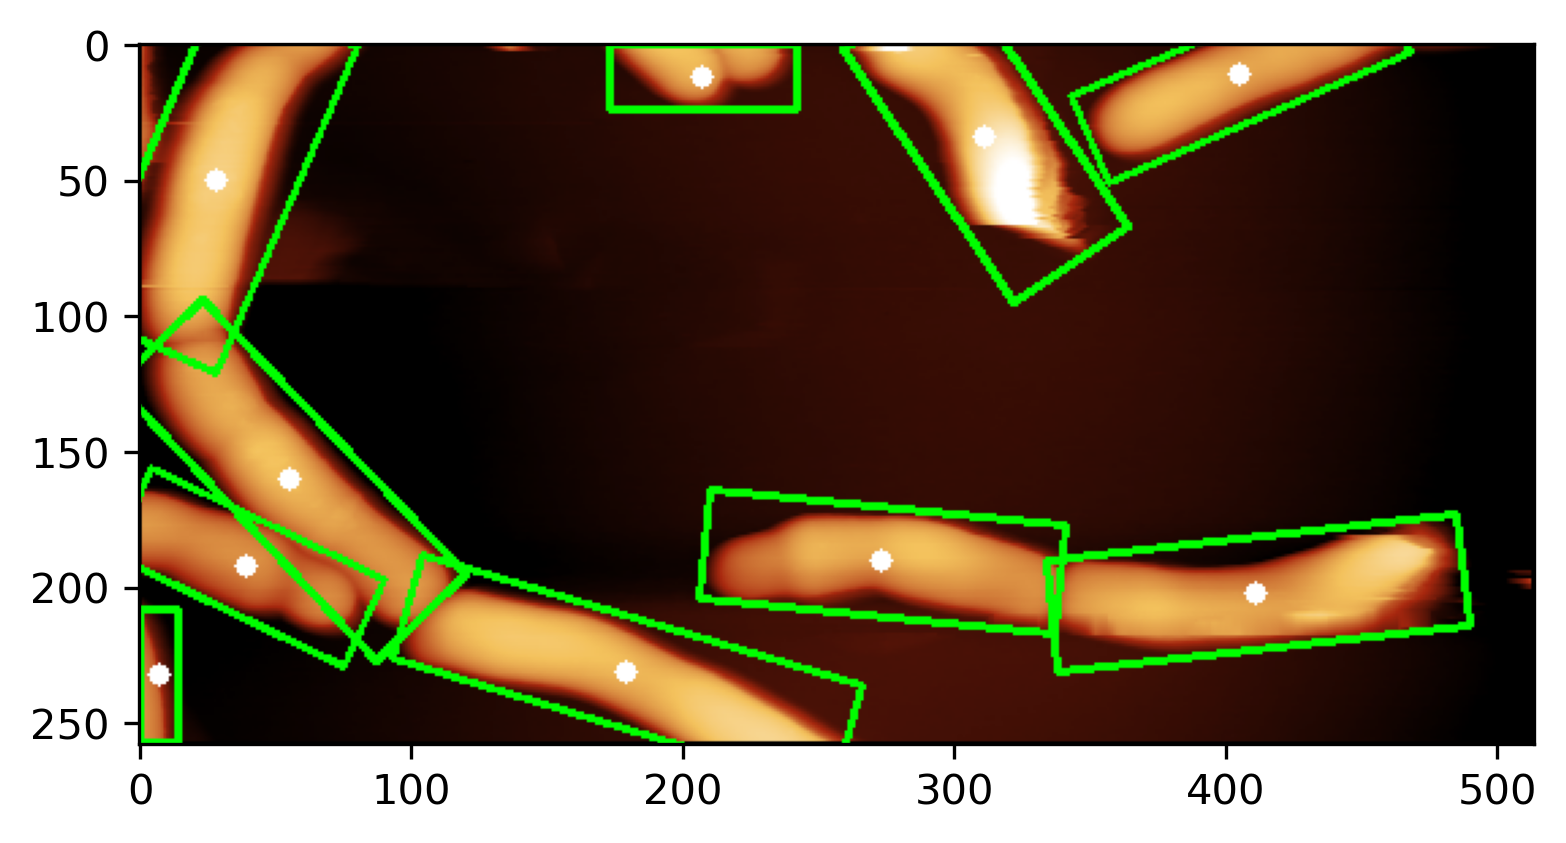

In [10]:
plt.imshow(box_img_list[7])

# Determining overlap

In [8]:
# An earlier version that just draws the lines for educative purposes. 
img_lines = img.copy()
for out_cell, cen_cell in zip(outl, centers):
    for cen_oth in centers:
        distance = dist.euclidean(cen_cell,cen_oth)
        if distance > 150 or distance == 0:
            continue
        cv2.line(img_lines, (int(cen_cell[0]),int(cen_cell[1])), (int(cen_oth[0]),int(cen_oth[1])), color = (0, 0, 255))

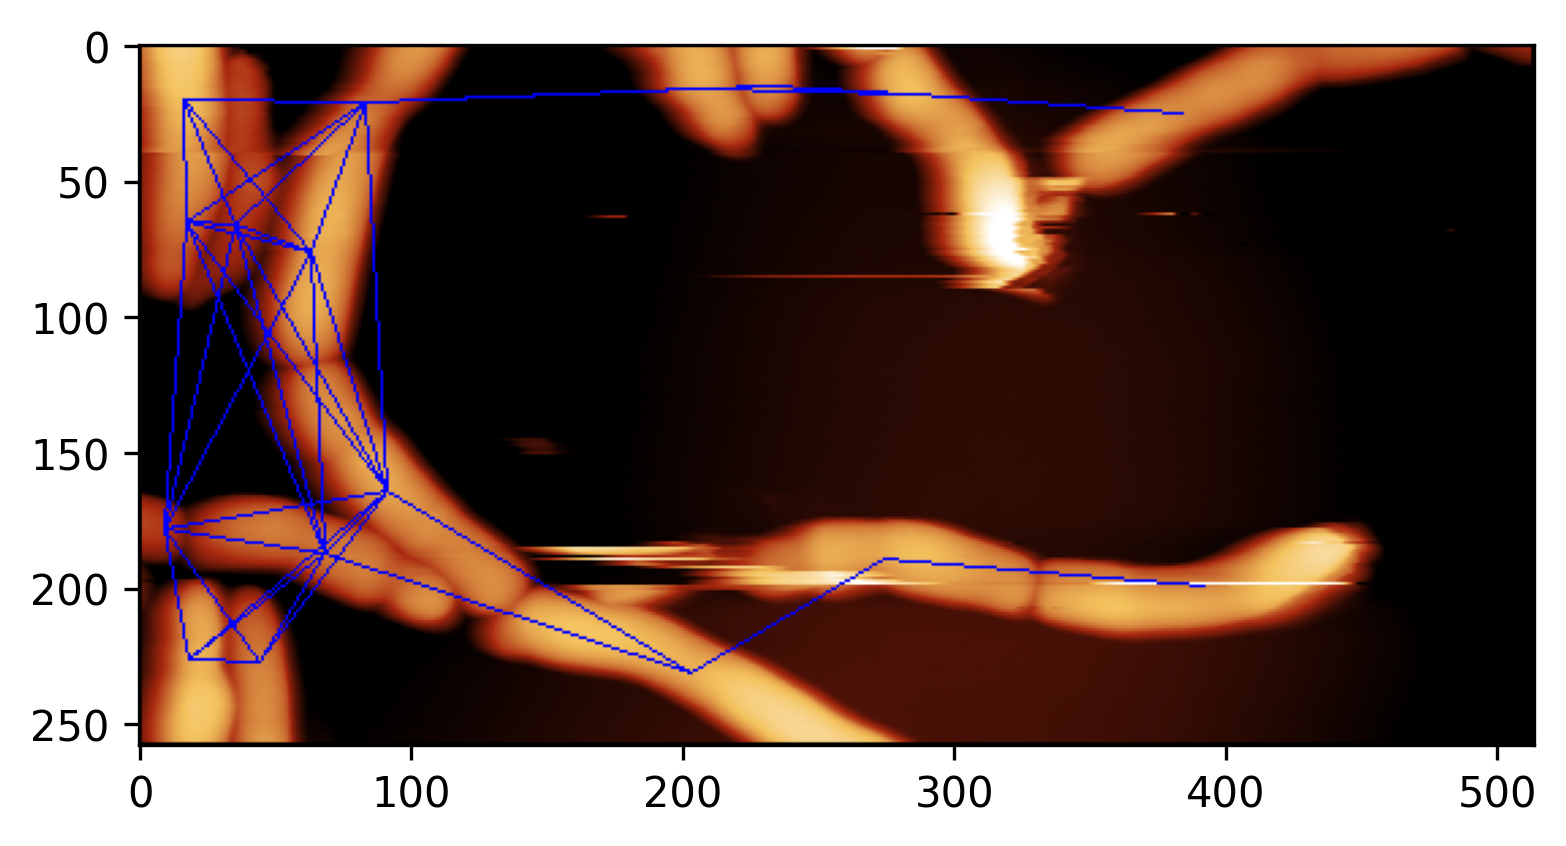

In [10]:
plt.imshow(img_lines)

In [145]:
# hmmmm, this takes like, 10 seconds to run, and for an image of this size that is pretty pathetic... 
overl_list = []
for outl, centers in zip(outl_list, centers_list):
    cell_overlaps = []
    for out_cell, cen_cell in zip(outl, centers):
        adj = 0
        for out_oth, cen_oth in zip(outl, centers):
            cent_dist = dist.euclidean(cen_cell,cen_oth)
            if cent_dist > 150 or cent_dist == 0:
                continue
            for pixel1 in out_cell:
                for pixel2 in out_oth:
                    distx = np.abs(pixel1[0]-pixel2[0])
                    disty = np.abs(pixel1[1]-pixel2[1])
                    if distx + disty == 1:
                        adj = adj + 1
        cell_overlaps.append(adj)
    overl_list.append(cell_overlaps)

# Box Idea
The box idea is way harder than I thought. It still might be possible by just creating a whole bunch of lines and just checking all of them for intersection, but for now I cannot work at this any longer. 

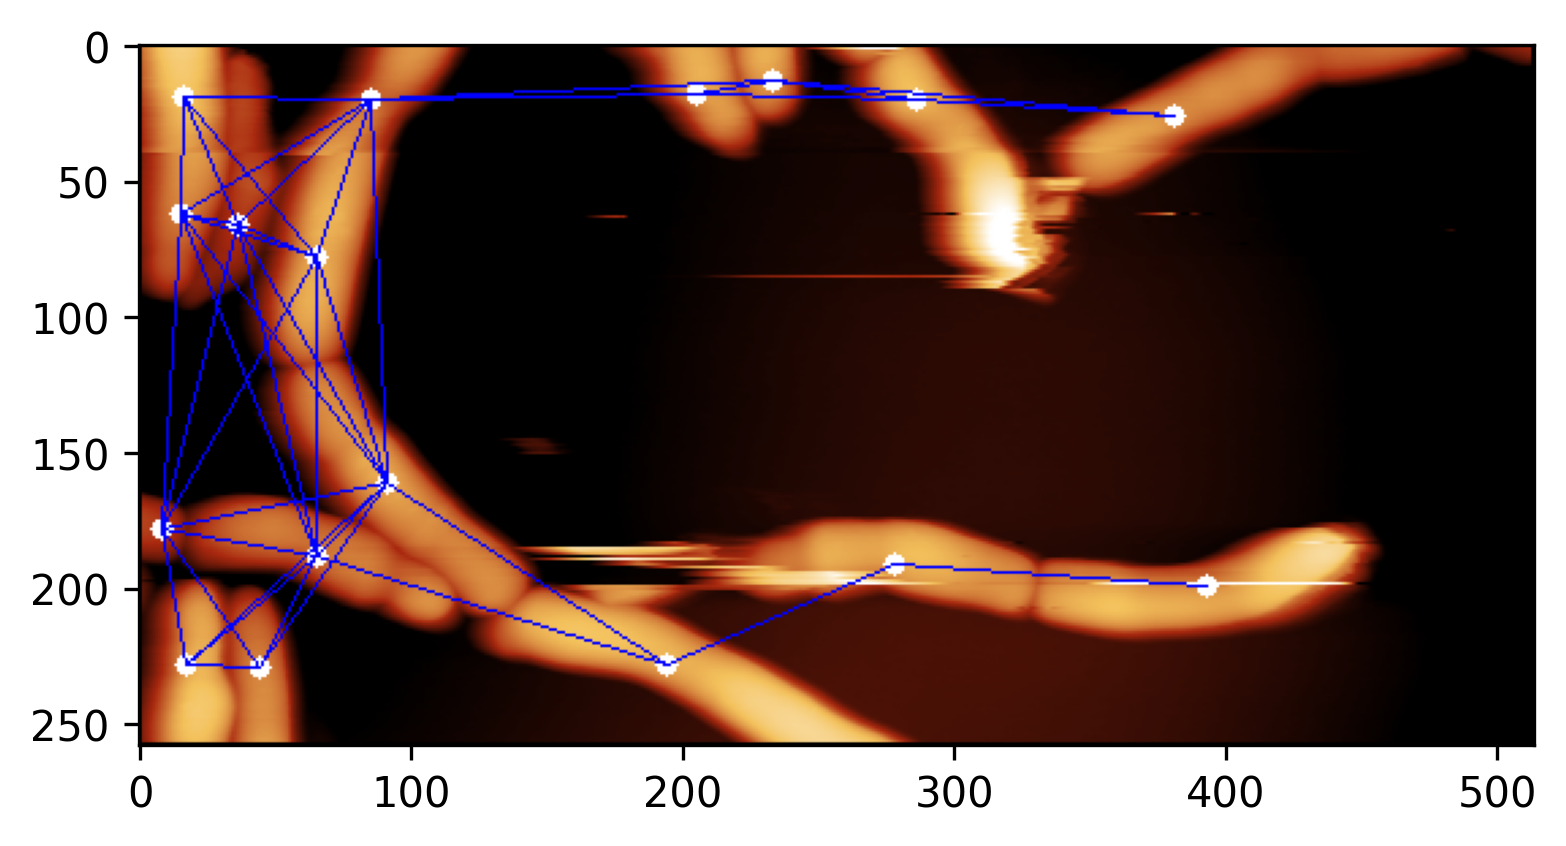

In [24]:
plt.imshow(img_centers)

### For now, I have set the cuttoff at 150 pixels distance from the centroid.

# Putting it all together. 

I want to start creating a table where, for each cell, we have the perimeter, the area, the amount of overlap, the position of the center, 

In [21]:
# calculate some extra values. 
perimeters = utils.get_mask_perimeters(dat['masks'])
areas = []
for o in outl:
    areas.append(cv2.contourArea(o))


In [25]:
print(centers)
print(cell_overlaps)
print(perimeters)
print(areas)

[[ 16  19]
 [ 85  20]
 [205  18]
 [233  13]
 [286  20]
 [381  26]
 [ 36  66]
 [ 15  62]
 [ 65  78]
 [ 91 161]
 [ 65 188]
 [  8 178]
 [278 191]
 [393 199]
 [ 17 228]
 [ 44 229]
 [194 228]]
[32, 50, 39, 39, 0, 0, 142, 108, 131, 157, 113, 20, 27, 27, 59, 59, 35]
[134.72792206 180.02438662 158.12489168  99.11269837 184.50966799
 262.93607486 165.88225099 157.35533906 237.88225099 305.06096654
 261.13708499  69.55634919 278.36753237 311.92388155 175.11269837
 156.18376618 370.1492783 ]
[1105.5, 1545.0, 1291.5, 611.0, 1700.0, 2842.0, 1044.0, 1299.5, 2943.0, 3829.5, 2680.0, 296.5, 2971.0, 3759.5, 1736.0, 1257.5, 3890.5]


## Save individual masks as png files

In [4]:
for idx, cell in enumerate(outl[:]):
    # mask outline
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, [cell], ignore_mask_color)
    
    # crop the cell
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = mask[topy:bottomy+1, topx:bottomx+1]
    
    #cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
    im = Image.fromarray(out)
    im.save("Individual_masks/" + str(idx) + ".png")

In [ ]:
# Working on how I would like to save all of this metadata to file. 

def save_metadata(count_vectors, path_to_save):
    # Calculate the longest cds region in our new list of counts
    l_tr = find_max_list(count_vectors)

    # Define a header that includes labels for each value.
    header=["transcript_id","gene_id"]

    # insert that header into our counts list. 
    count_vectors.insert(0,header)
    
    # Save the newly altered list as a csv. 
    with open(path_to_save, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(count_vectors)

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. Completed!!! But improvements can be made to speed.
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine if cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears? Would such an event be biased by artifacts that occasionally split one cell into two cells? 

#### Hmmm, I need to start thinking of how I really want all of this to be organized. Like, I have to seperate every cell, but does he want me to put them back together? What are we trying to do with all this data?

# Ultimate goal. 
For each cell, there is a table of metadat. The columns of this metadata table are the parameters we are interested in (overlap, length of skeleton, ridgeline, etc) The rows of the table are time points, so that at each timepoint we have every parameter of interest. This could allow us to see things like the volume change after division or the path of movement that a cell takes.

# Note on potential issue:
I have noticed that the AFM data tends to create these "fault lines" where one cell ends up being split in two by some kind of glitch along the scanning line. This may be of some concern given that cellpose tends to think that these split cells are actually seperate cells. 

# Tracking

In [11]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None) ## Perhaps I could fix my issues with frame by messing with this? 

# loop over the images and their boxes.
for rects, img in zip(boxes_list[8:], img_list[8:]):
    for box in rects:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)
    # update our centroid tracker using the computed set of bounding
    # box rectangles
    objects = ct.update(rects)
    # loop over the tracked objects
    for (objectID, centroid) in objects.items(): ###!!!### This is going to be key for figuring out what is ha
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (centroid[0] - 10, centroid[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

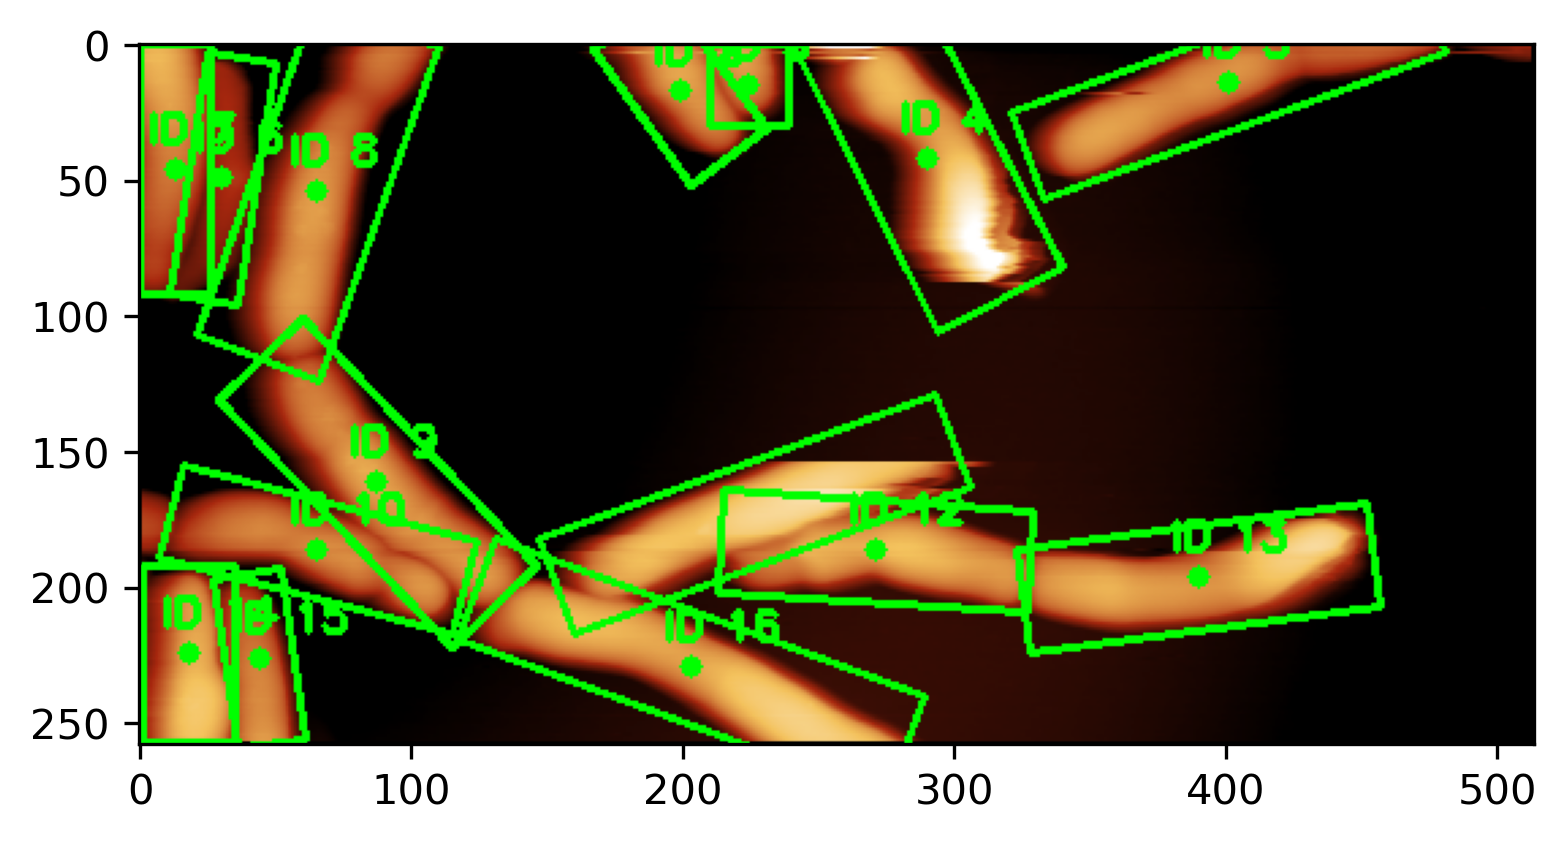

In [12]:
plt.imshow(img_list[9])

It works somewhat ok.

Some of the problems are that it actually does not quite deregister fast enough, which occasionally makes the phantom centroids very dangerous. 

Also, how the hell do I actually extract the ID information from in here? 